In [1]:
import numpy as np
import pickle

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
data_path = 'parsed_data_no_timestamps.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)
print(f"Shape of full dataset: {data.shape}")

X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

Shape of full dataset: (2933, 90, 5)
(2346, 80, 5) (587, 80, 5) (2346, 10, 5) (587, 10, 5)


In [3]:
import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1):  # Set default n to 10
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_features * output_timesteps) 
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        _, (hn, _) = self.lstm(x)
        # hn: (num_layers, batch_size, hidden_size)
        out = self.fc(hn[-1])
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, input_size)

In [4]:
from torch.utils.data import DataLoader, TensorDataset
from loss_functions import get_loss_function
import torch
import os

# Initialize lists to store loss history
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10, loss_config=None):
    # Dynamically load the loss function
    criterion = get_loss_function(**loss_config)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

    best_val_loss = float('inf')  # Initialize the best validation loss
    model_save_path = "best_model.pth"  # Save path for the best model

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0

        # Training loop
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Custom loss
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_train_loss += loss.item()

        scheduler.step()

        # Average training loss
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()

            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

            # Save the model if it has the best validation loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), model_save_path)
                print(f"Saved best model with validation loss: {best_val_loss:.4f}")

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}. Model saved to {model_save_path}.")

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
input_size = X_train.shape[2]
hidden_size = 64
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=4).to("cuda")

# Loss configuration
loss_config = {
    "loss_name": "trajectory_loss",
    "use_velocity_loss": True,
    "use_smoothness_loss": True,
    "use_terminal_loss": True,
}

# Train the model
train_model(model, train_loader, val_loader, num_epochs=100, initial_lr=1e-2, T_max=50, loss_config=loss_config)


Epoch [1/100], Training Loss: 3193.8637, LR: 0.009990
Epoch [1/100], Validation Loss: 1404.9974
Saved best model with validation loss: 1404.9974
Epoch [2/100], Training Loss: 2825.8007, LR: 0.009961
Epoch [2/100], Validation Loss: 1318.1413
Saved best model with validation loss: 1318.1413
Epoch [3/100], Training Loss: 2625.0760, LR: 0.009911
Epoch [3/100], Validation Loss: 1284.6348
Saved best model with validation loss: 1284.6348
Epoch [4/100], Training Loss: 2516.7044, LR: 0.009843
Epoch [4/100], Validation Loss: 1214.1222
Saved best model with validation loss: 1214.1222
Epoch [5/100], Training Loss: 2495.1370, LR: 0.009755
Epoch [5/100], Validation Loss: 1233.3412
Epoch [6/100], Training Loss: 2676.5729, LR: 0.009649
Epoch [6/100], Validation Loss: 1375.6616
Epoch [7/100], Training Loss: 2427.1644, LR: 0.009524
Epoch [7/100], Validation Loss: 1174.4778
Saved best model with validation loss: 1174.4778
Epoch [8/100], Training Loss: 2324.0925, LR: 0.009382
Epoch [8/100], Validation Los

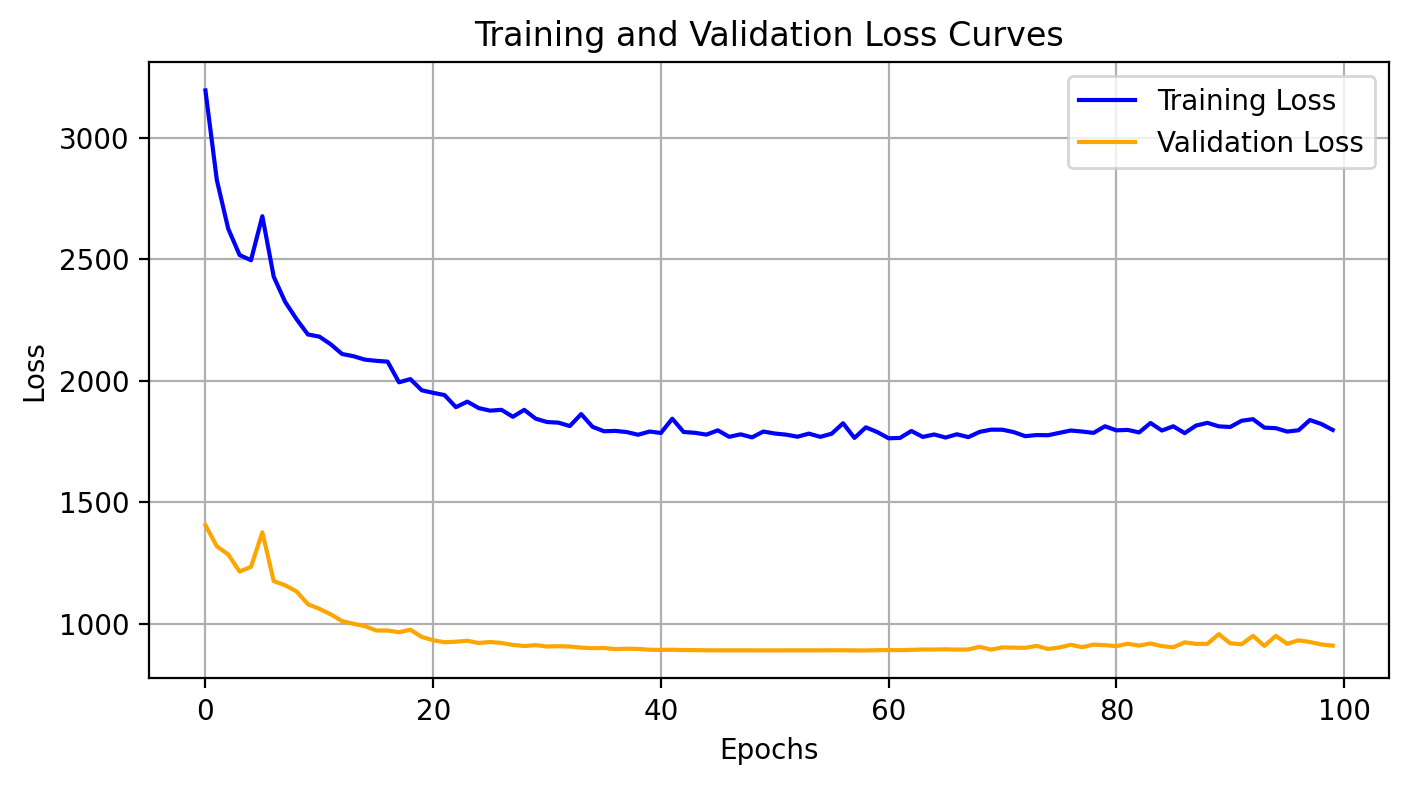

In [5]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(train_losses, val_losses)

In [6]:
x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()

print("Mean ADE:", mean_ade)

Mean ADE: 7.109597682952881


In [7]:
# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

print(past_traj[:, :2])

[[ 0.00000000e+00  0.00000000e+00]
 [ 1.95312500e-03  3.90625000e-03]
 [ 1.95312500e-03  9.76562500e-03]
 [ 1.95312500e-03  1.17187500e-02]
 [-6.83593750e-03 -8.78906250e-03]
 [ 1.95312500e-03  2.92968750e-03]
 [-2.92968750e-03 -7.81250000e-03]
 [-9.76562500e-04 -5.85937500e-03]
 [ 2.92968750e-03 -9.76562500e-04]
 [ 1.66015625e-02  1.56250000e-02]
 [ 2.73437500e-02  3.22265625e-02]
 [ 2.34375000e-02  2.63671875e-02]
 [ 4.39453125e-02  4.49218750e-02]
 [ 5.66406250e-02  6.25000000e-02]
 [ 6.83593750e-02  8.69140625e-02]
 [ 7.91015625e-02  1.02539062e-01]
 [ 9.96093750e-02  1.22070312e-01]
 [ 1.17187500e-01  1.50390625e-01]
 [ 1.40625000e-01  1.86523438e-01]
 [ 1.70898438e-01  2.40234375e-01]
 [ 1.97265625e-01  2.79296875e-01]
 [ 2.27539062e-01  3.30078125e-01]
 [ 2.68554688e-01  3.99414062e-01]
 [ 3.24218750e-01  4.81445312e-01]
 [ 3.99414062e-01  5.85937500e-01]
 [ 4.72656250e-01  7.24609375e-01]
 [ 5.74218750e-01  8.72070312e-01]
 [ 6.69921875e-01  1.03027344e+00]
 [ 7.80273438e-01  1

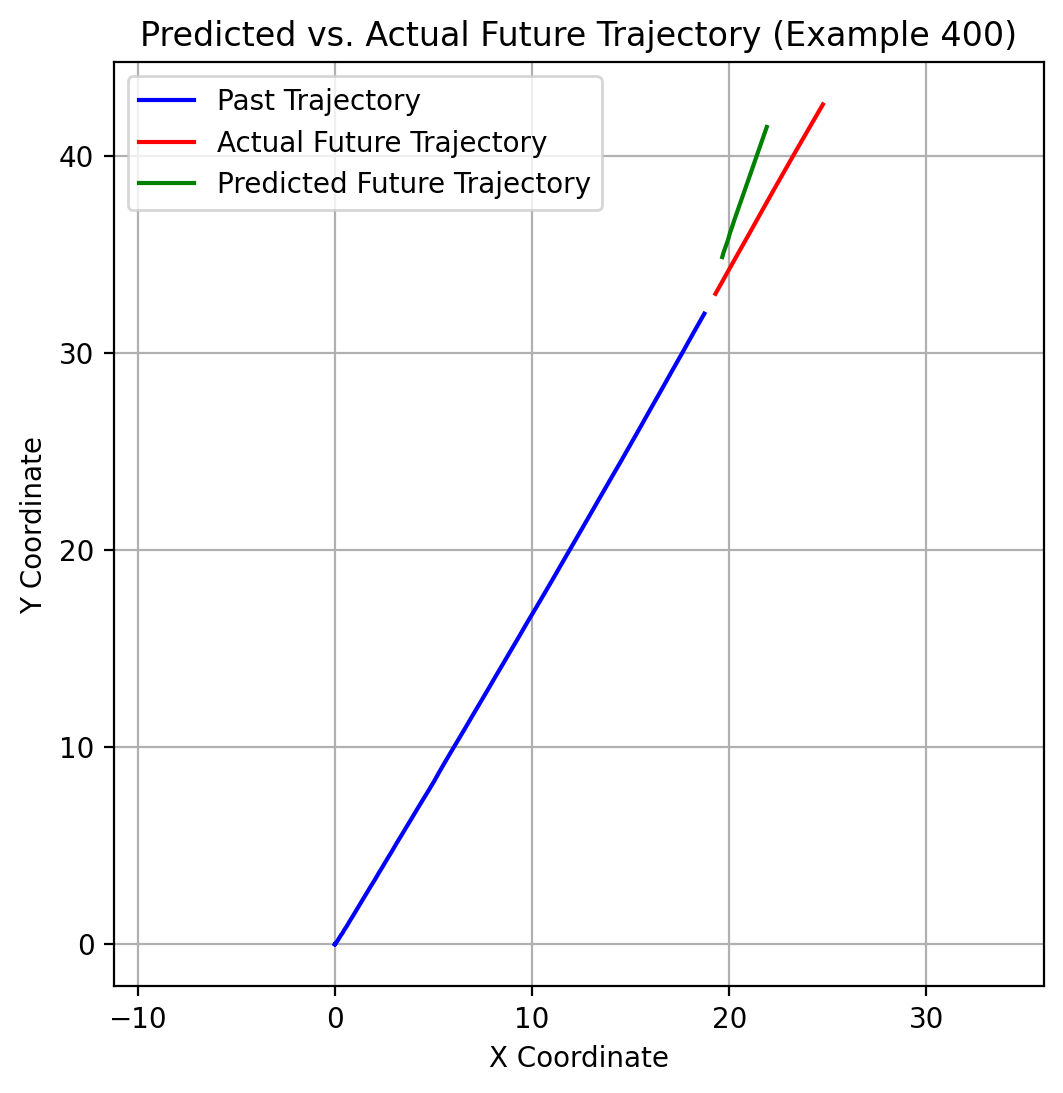

In [8]:
# Plot the past trajectory, actual future trajectory, and predicted future trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()